In [1]:
import scvelo as scv
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm import tnrange, tqdm_notebook
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline


scv.logging.print_version()
scv.settings.set_figure_params(
    'scvelo', dpi_save=100, dpi=80, transparent=True)
scv.settings.verbosity = 2

Running scvelo 0.1.16.dev32+c00a55e.dirty (python 3.6.6) on 2020-12-14 18:25.


In [2]:
# paths and names
data_path='G:/data/scSLAMseq/revision/'
signatures_path='G:/data/scrnaseq_signature_collection/'
figure_path='G:/data/figures/heatmaps/'
libraries = ['AB', 'CE', 'DF']
donors=['B2-040', 'C2-019', 'OT227', 'OT302', 'P009T', 'P013T']

In [3]:
# load preformated and filtered data (not normalized and logscaled)
donor = donors[-1]
adata=sc.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed_ccreg.h5')

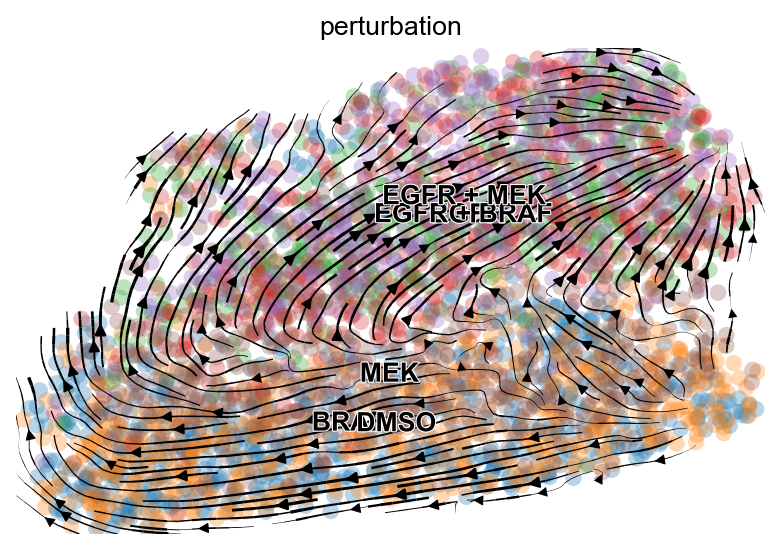

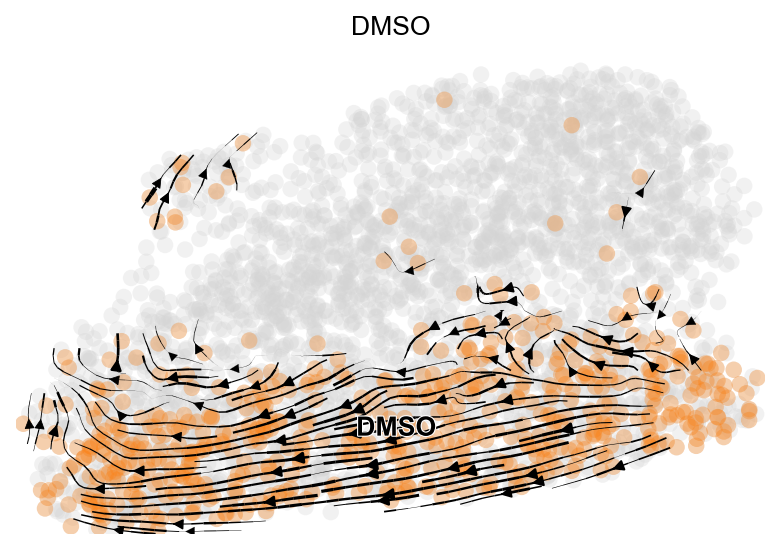

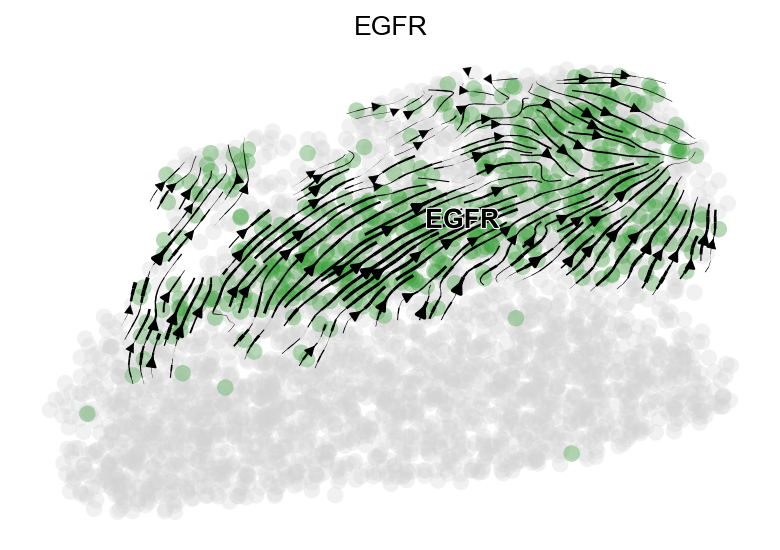

In [23]:
scv.pl.velocity_embedding_stream(adata, color='perturbation', perc=[1,99], vkey='SLAM_velocity')
scv.pl.velocity_embedding_stream(adata, color='perturbation', perc=[1,99], groups=['DMSO'], vkey='SLAM_velocity')
scv.pl.velocity_embedding_stream(adata, color='perturbation', perc=[1,99], groups=['EGFR'], vkey='SLAM_velocity')

In [24]:
color=[
    'Stem_Lgr5_ISC-Munoz', 'Stem_Lgr5_ISC-Merlos', 'Stem', 'Enterocytes 1', 'Enterocytes 2', 'TC1', 'TC4', 'Goblet',
    'YAP_targets', 'Stem/TA 1', 'Stem/TA 2',
]
color = ['YAP_targets', 'MAPK_progeny', 'HALLMARK_DNA_REPAIR', 'WNT_progeny', 'Stem_Lgr5_ISC-Merlos', 'TC1', 'TC4', 'Goblet']

In [25]:
adata.obs.keys()

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO',
       'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin',
       'HTO_classification', 'HTO_classification.global', 'hash.ID',
       'percent.mt', 'organoid', 'perturbation', 'library',
       'percent_ribosomal', 'n_counts', 'S_score', 'G2M_score', 'phase',
       'Stem_Lgr5_ISC-Munoz', 'Stem_Lgr5_ISC-Merlos', 'Stem', 'Enterocytes 1',
       'Enterocytes 2', 'TC1', 'TC2', 'TC3', 'TC4', 'Goblet', 'Stem_TA 1',
       'Stem_TA 2', 'Stem_TA 3', 'HALLMARK_DNA_REPAIR',
       'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'YAP_targets',
       'Androgen_progeny', 'EGFR_progeny', 'Estrogen_progeny',
       'Hypoxia_progeny', 'JAK-STAT_progeny', 'MAPK_progeny', 'NFkB_progeny',
       'p53_progeny', 'PI3K_progeny', 'TGFb_progeny', 'TNFa_progeny',
       'Trail_progeny', 'VEGF_progeny', 'WNT_progeny',
       'SLAM_velocity_self_transition', 'real_velocity_self_transition'],
      dtype='object')

# Order along umap dimension

Does not show flipped dynamics if there

In [26]:
from scipy.stats import zscore

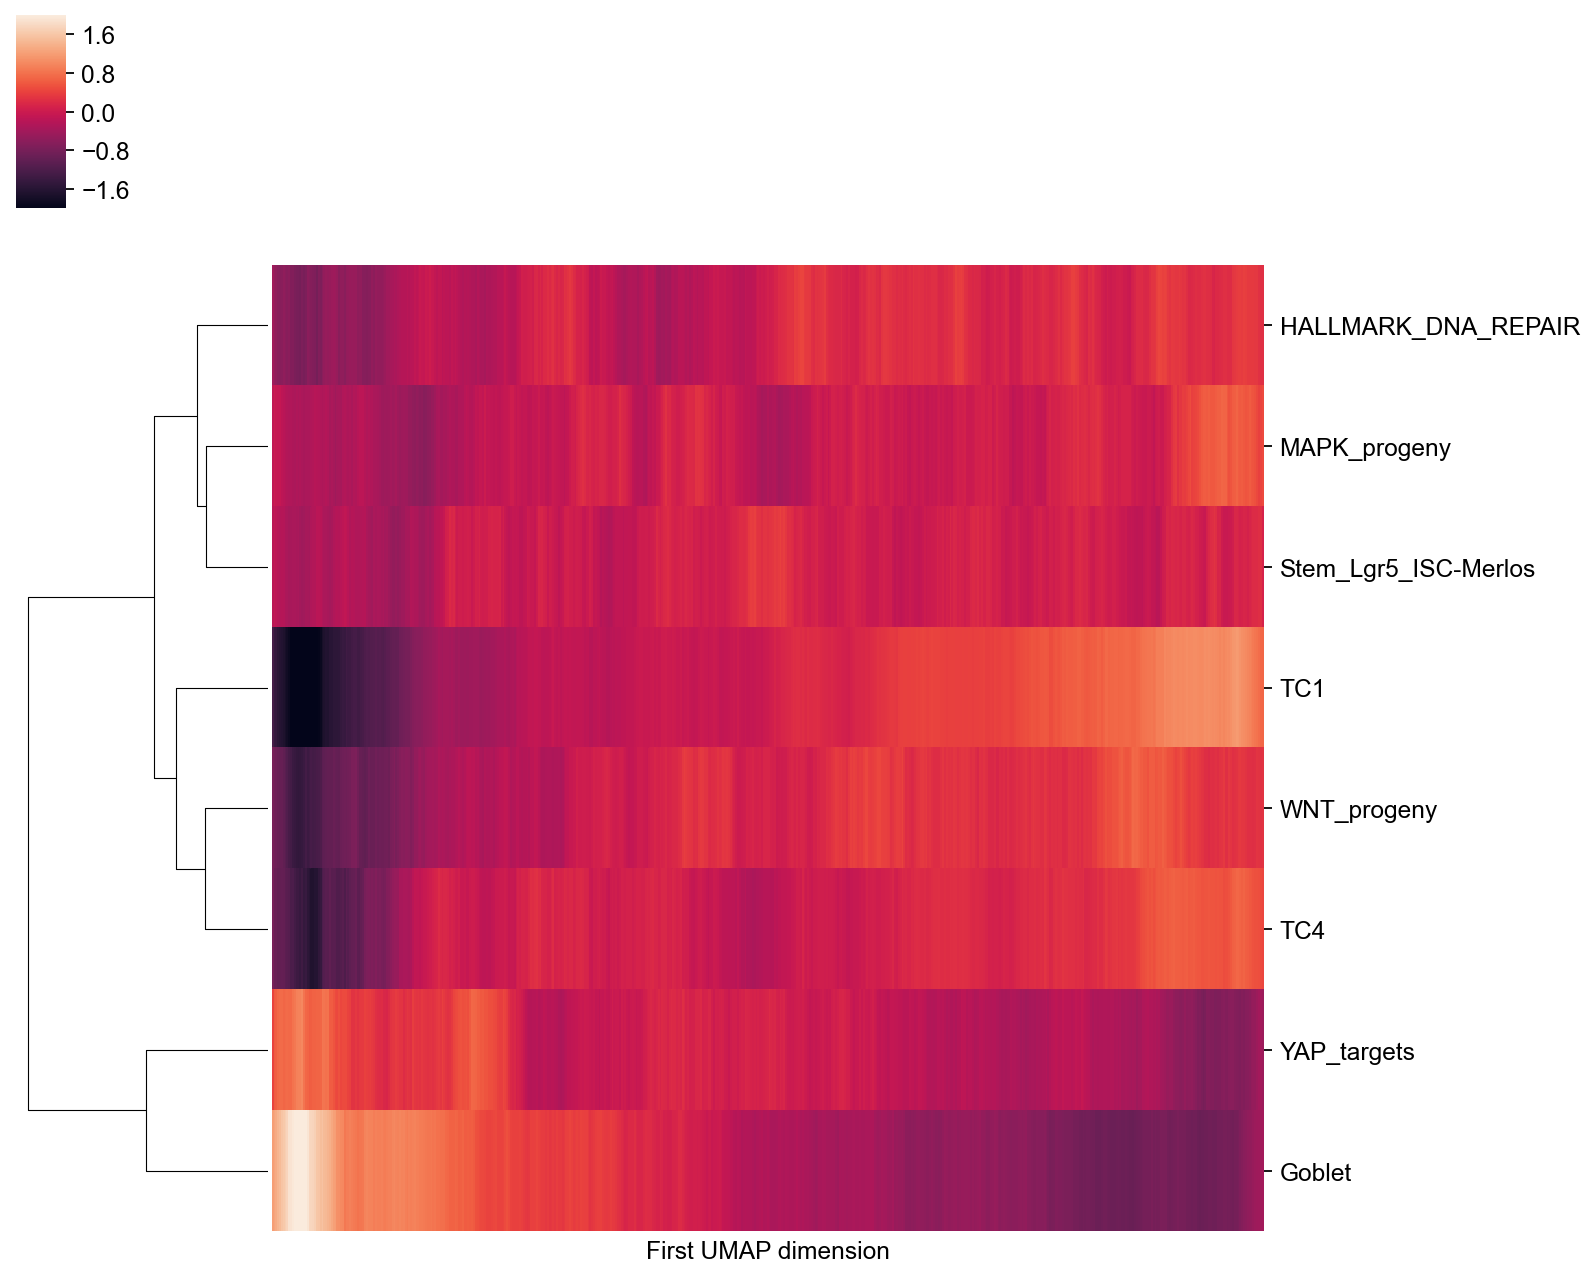

In [30]:
bdata = adata[adata.obs.perturbation=='EGFR'].copy()
time = bdata.obsm['X_umap'][:,0]
obs_names = np.array(color)
Y=bdata.obs[obs_names].iloc[np.argsort(time)]

#Y/=np.max(np.abs(Y), axis=0)
Y=zscore(Y)
df = pd.DataFrame(Y, columns=obs_names)

if True:
    n_convolve=30
    weights = np.ones(n_convolve) / n_convolve
    for obs in obs_names:
        try:
            df[obs] = np.convolve(df[obs].values, weights, mode="same")
        except:
            pass  # e.g. all-zero counts or nans cannot be convolved

from seaborn import clustermap
cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2)#, **kwargs
cm.ax_heatmap.set_xlabel('First UMAP dimension');
cm.ax_heatmap.set_xticks([]);

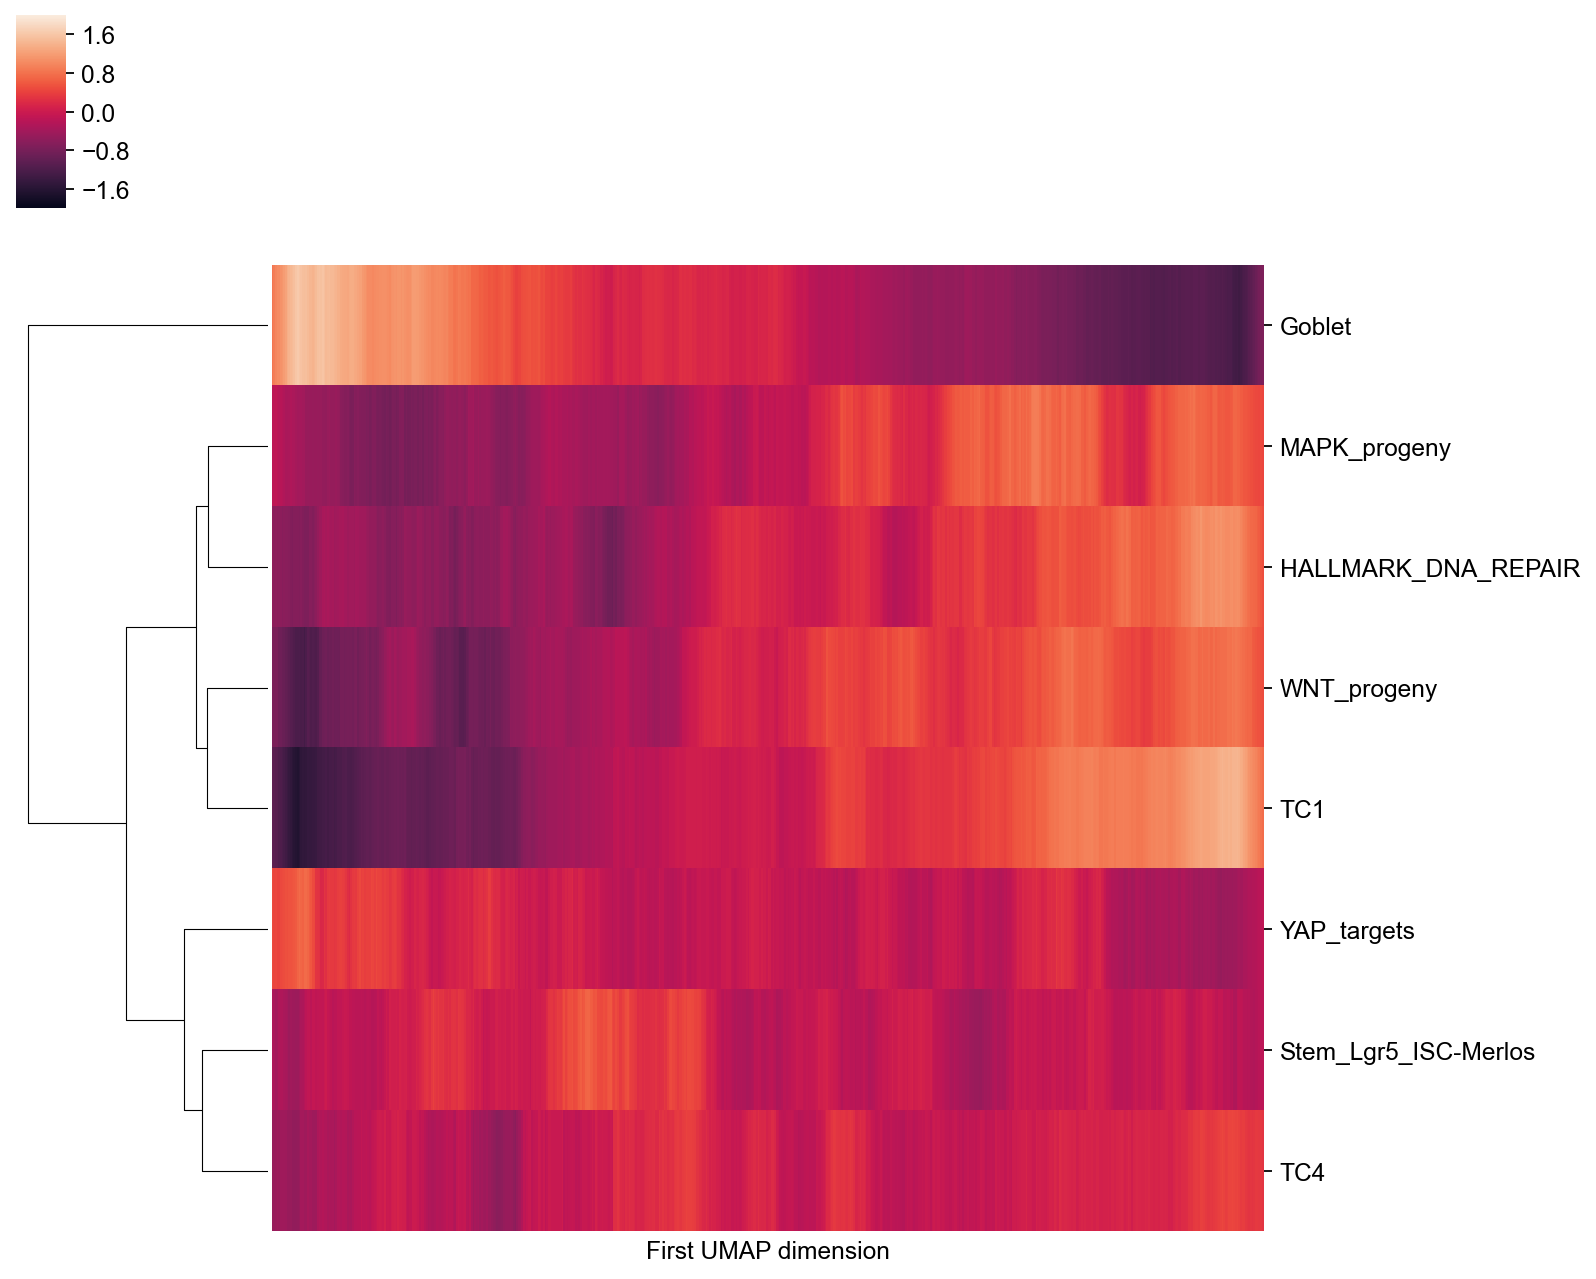

In [28]:
bdata = adata[adata.obs.perturbation=='DMSO'].copy()
time = bdata.obsm['X_umap'][:,0]
obs_names = np.array(color)
Y=bdata.obs[obs_names].iloc[np.argsort(time)]

#Y/=np.max(np.abs(Y), axis=0)
Y=zscore(Y)
df = pd.DataFrame(Y, columns=obs_names)

if True:
    n_convolve=30
    weights = np.ones(n_convolve) / n_convolve
    for obs in obs_names:
        try:
            df[obs] = np.convolve(df[obs].values, weights, mode="same")
        except:
            pass  # e.g. all-zero counts or nans cannot be convolved

from seaborn import clustermap
cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2)#, **kwargs
cm.ax_heatmap.set_xlabel('First UMAP dimension');
cm.ax_heatmap.set_xticks([]);

# dynamic linear orthogonal projection

In [31]:
def project_on_plane(u,n):
    a=(np.dot(u, n)/np.linalg.norm(n)**2)
    return np.expand_dims(a, axis=1) * n

def proj_distance(u,n):
    return np.linalg.norm(project_on_plane(u,n), axis=-1)

Projection of Vector u on Plane P is:  [-1.5  1.5]
(3, 2) (2,)


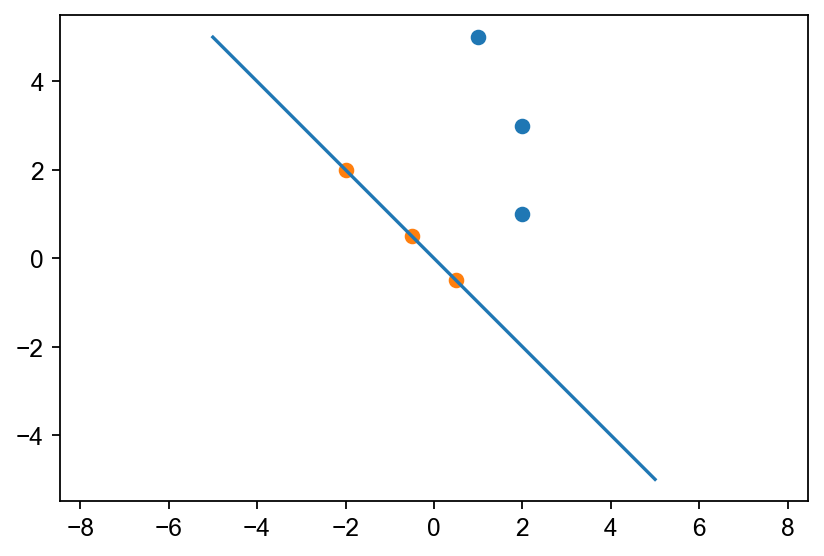

In [32]:
# demonstration
# vector u  
u = np.array([2, 5])        
  
# vector n: n is orthogonal vector to Plane P 
n = np.array([1, 1])        

n_norm = np.linalg.norm(n)#np.sqrt(sum(n**2))     
   
# Apply the formula as mentioned above 
# for projecting a vector onto the orthogonal vector n 
# find dot product using np.dot() 
proj_of_u_on_n = (np.dot(u, n)/n_norm**2)*n 
  
# subtract proj_of_u_on_n from u:  
# this is the projection of u on Plane P 
print("Projection of Vector u on Plane P is: ", u - proj_of_u_on_n)

u=np.array([[1, 5], [2, 3], [2, 1]])
n = np.array([1, 1]) 
print(u.shape, n.shape)
y = project_on_plane(u,n)

pl.scatter(u[:,0], u[:,1])
pl.scatter((u-y)[:,0], (u-y)[:,1])
pl.plot([-5,0,5],[5,0,-5])
pl.axis('equal');

(3434, 31915) (31915,)


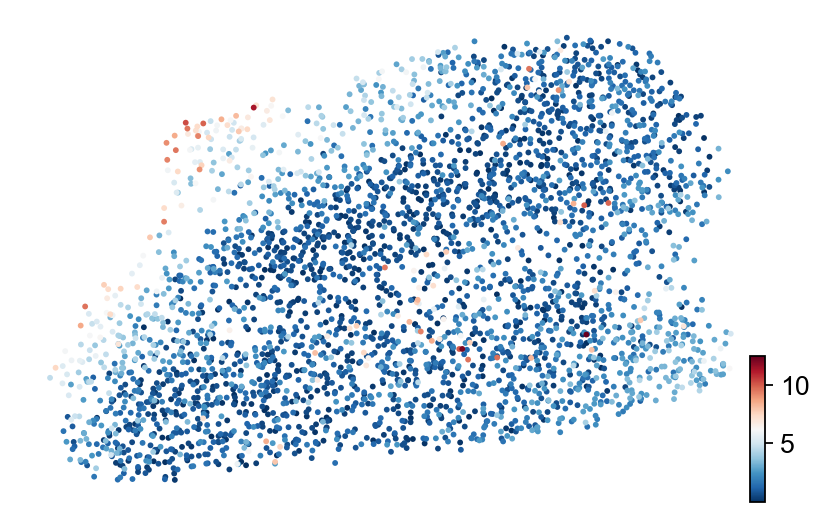

In [34]:
pert='DMSO'
vm=np.mean(adata[adata.obs.perturbation==pert].layers['SLAM_velocity'], axis=0)
vm.shape
u=adata.X
n=vm
print(u.shape, n.shape)
dists = proj_distance(u,n)

scv.pl.scatter(adata, basis='umap', color=dists)

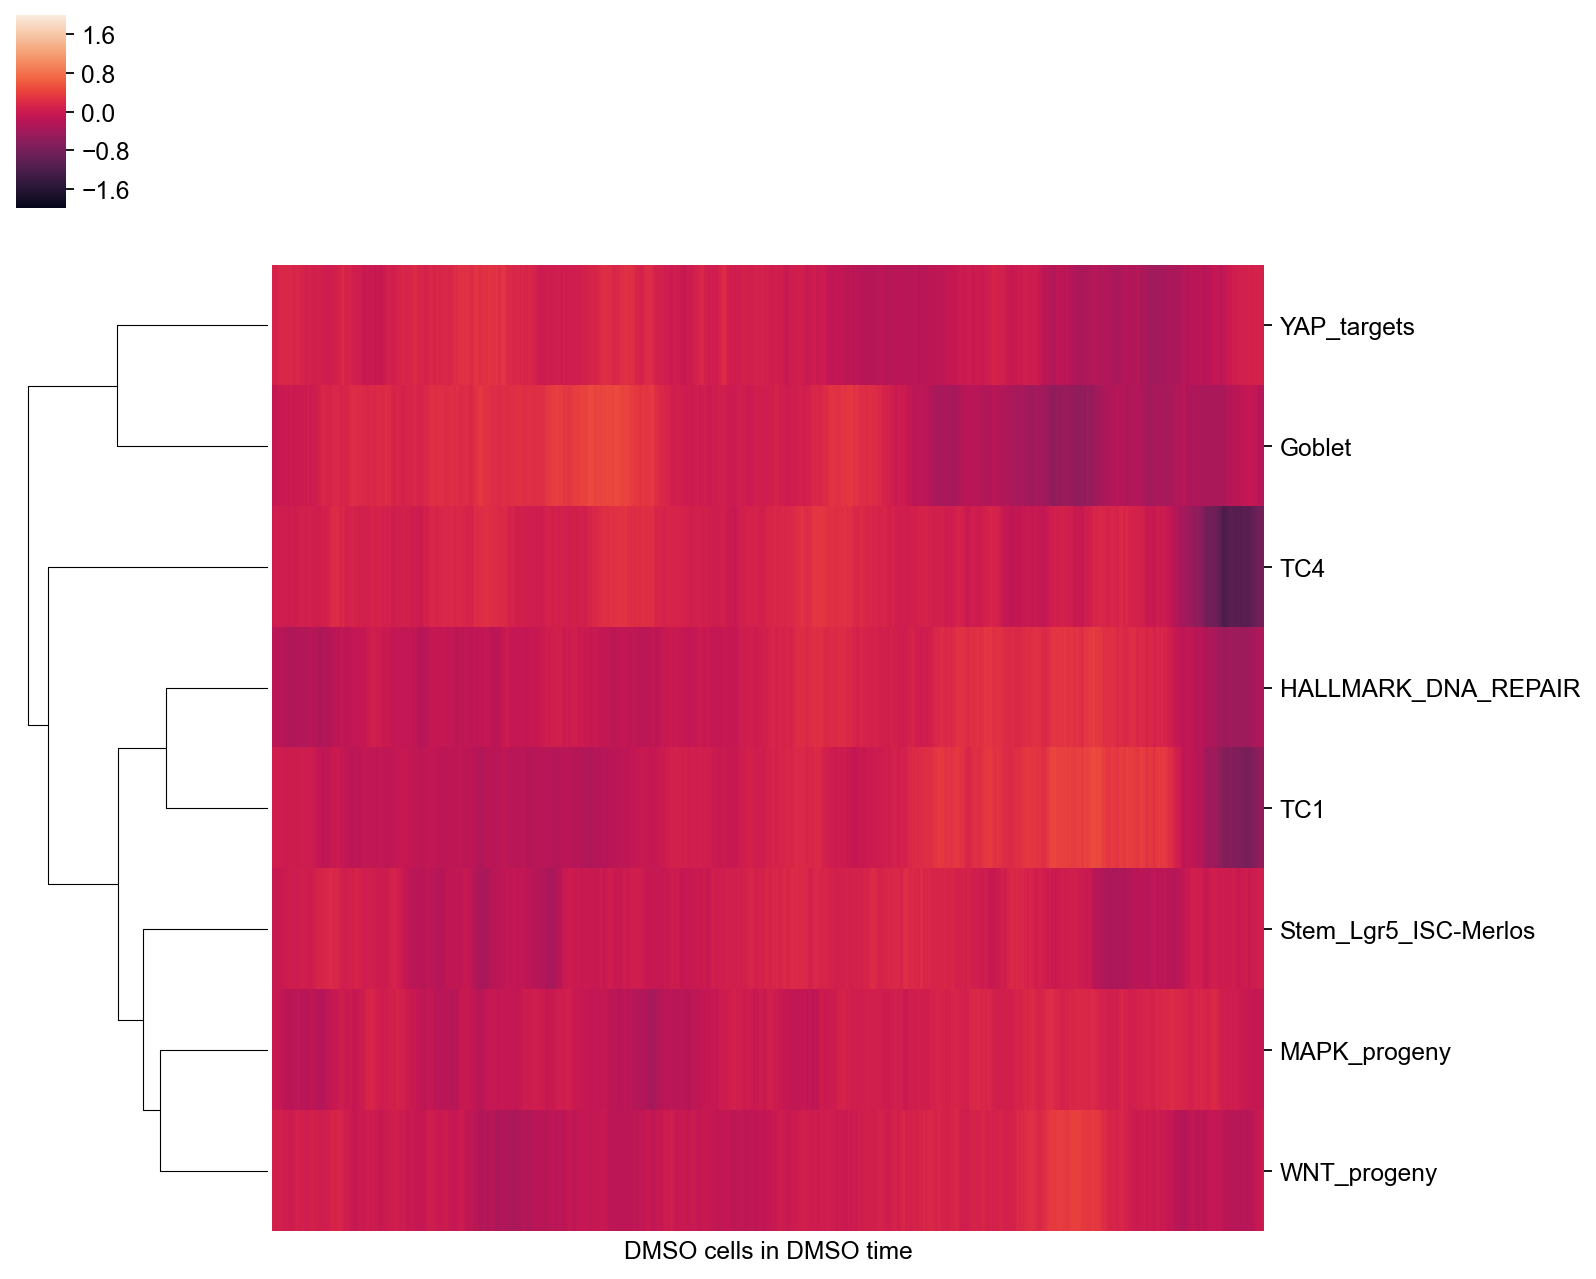

In [35]:
pert2=pert
bdata = adata[adata.obs.perturbation==pert2].copy()
time = dists[adata.obs.perturbation==pert2]
obs_names = np.array(color)
Y=bdata.obs[obs_names].iloc[np.argsort(time)]

#Y/=np.max(np.abs(Y), axis=0)
Y=zscore(Y)
df = pd.DataFrame(Y, columns=obs_names)

if True:
    n_convolve=50
    weights = np.ones(n_convolve) / n_convolve
    for obs in obs_names:
        try:
            df[obs] = np.convolve(df[obs].values, weights, mode="same")
        except:
            pass  # e.g. all-zero counts or nans cannot be convolved

from seaborn import clustermap
cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2)#, **kwargs
cm.ax_heatmap.set_xlabel(pert2+' cells in '+pert+ ' time');
cm.ax_heatmap.set_xticks([]);

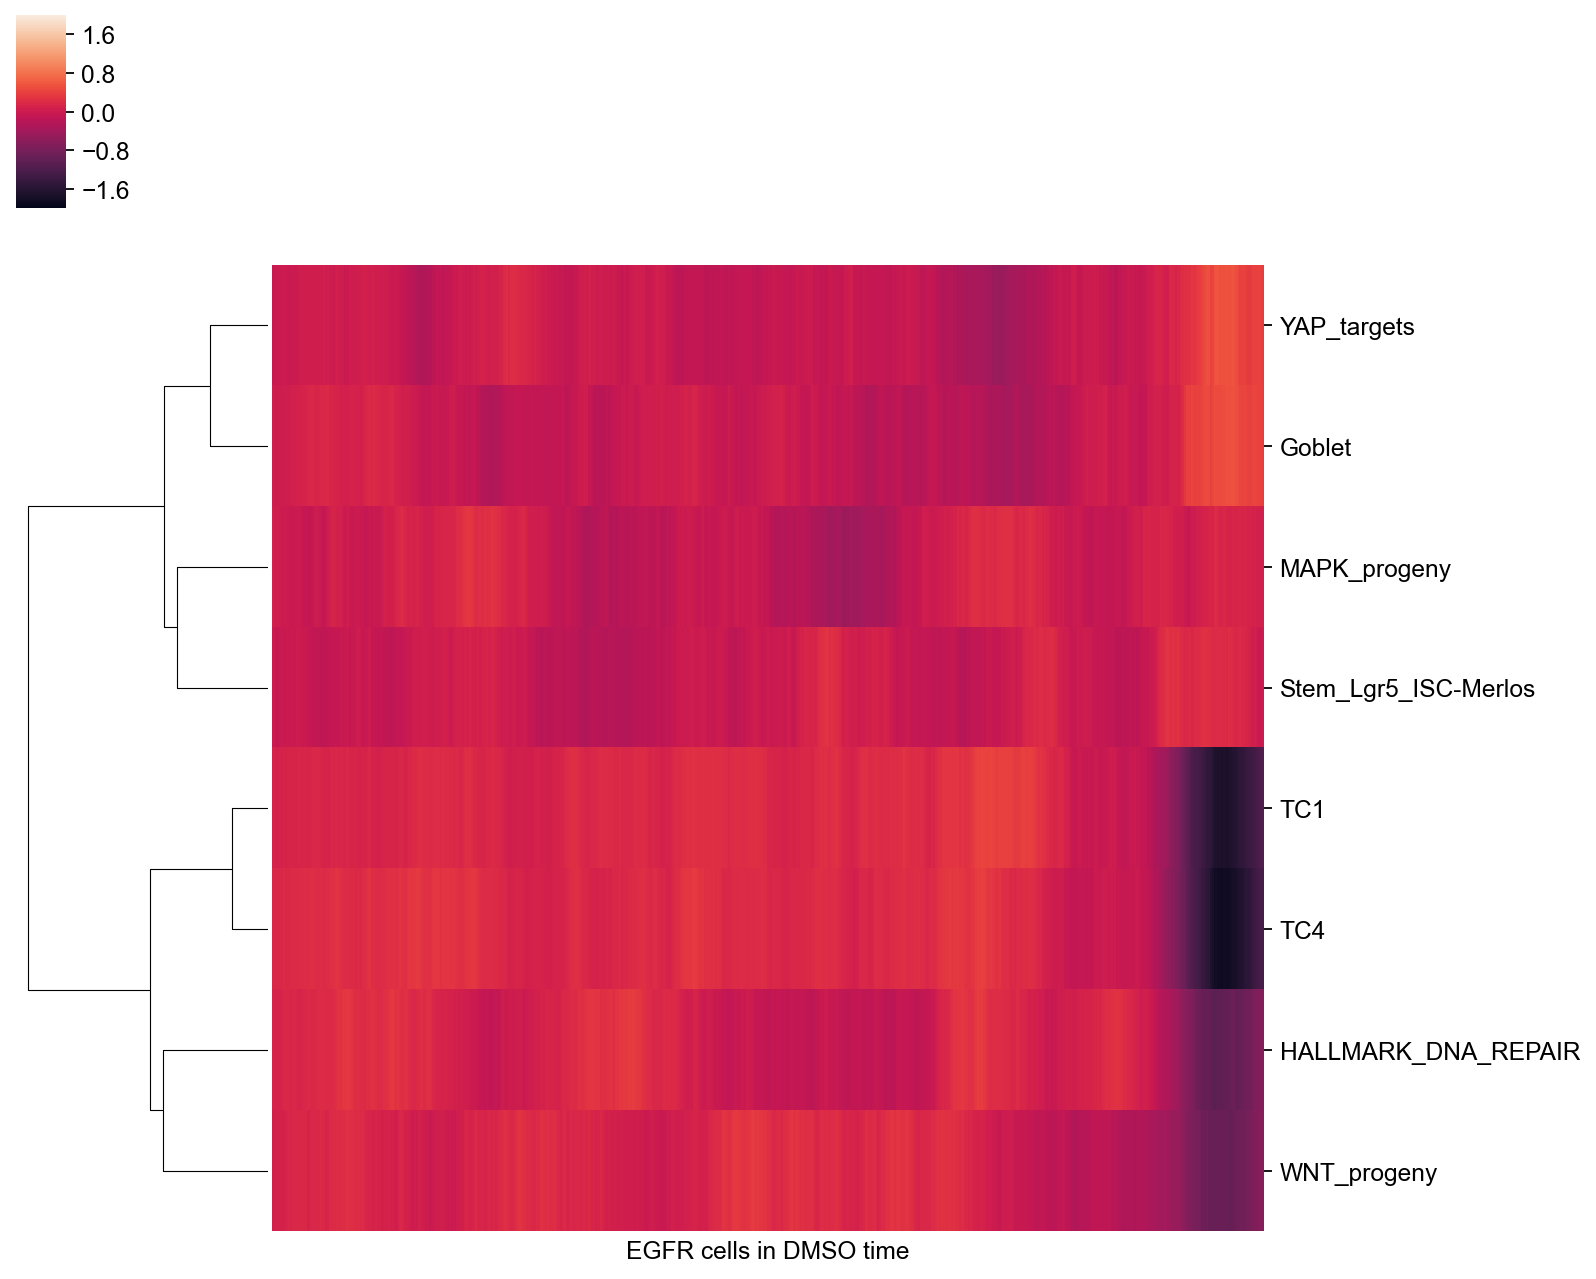

In [36]:
pert2='EGFR'
bdata = adata[adata.obs.perturbation==pert2].copy()
time = dists[adata.obs.perturbation==pert2]
obs_names = np.array(color)
Y=bdata.obs[obs_names].iloc[np.argsort(time)]

#Y/=np.max(np.abs(Y), axis=0)
Y=zscore(Y)
df = pd.DataFrame(Y, columns=obs_names)

if True:
    n_convolve=50
    weights = np.ones(n_convolve) / n_convolve
    for obs in obs_names:
        try:
            df[obs] = np.convolve(df[obs].values, weights, mode="same")
        except:
            pass  # e.g. all-zero counts or nans cannot be convolved

from seaborn import clustermap
cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2)#, **kwargs
cm.ax_heatmap.set_xlabel(pert2+' cells in '+pert+ ' time');
cm.ax_heatmap.set_xticks([]);

(3434, 31915) (31915,)


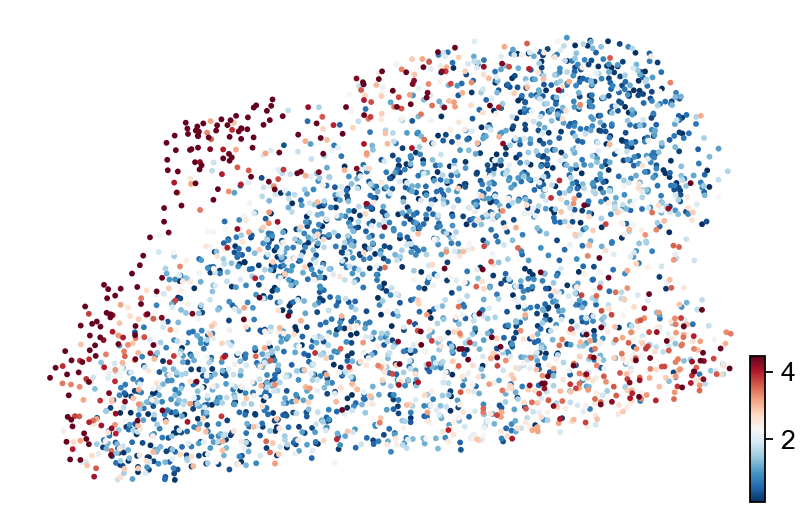

In [38]:
pert='MEK'
vm=np.mean(adata[adata.obs.perturbation==pert].layers['SLAM_velocity'], axis=0)
vm.shape
u=adata.X
n=vm
print(u.shape, n.shape)
dists = proj_distance(u,n)

scv.pl.scatter(adata, basis='umap', color=dists, perc=[5,95])

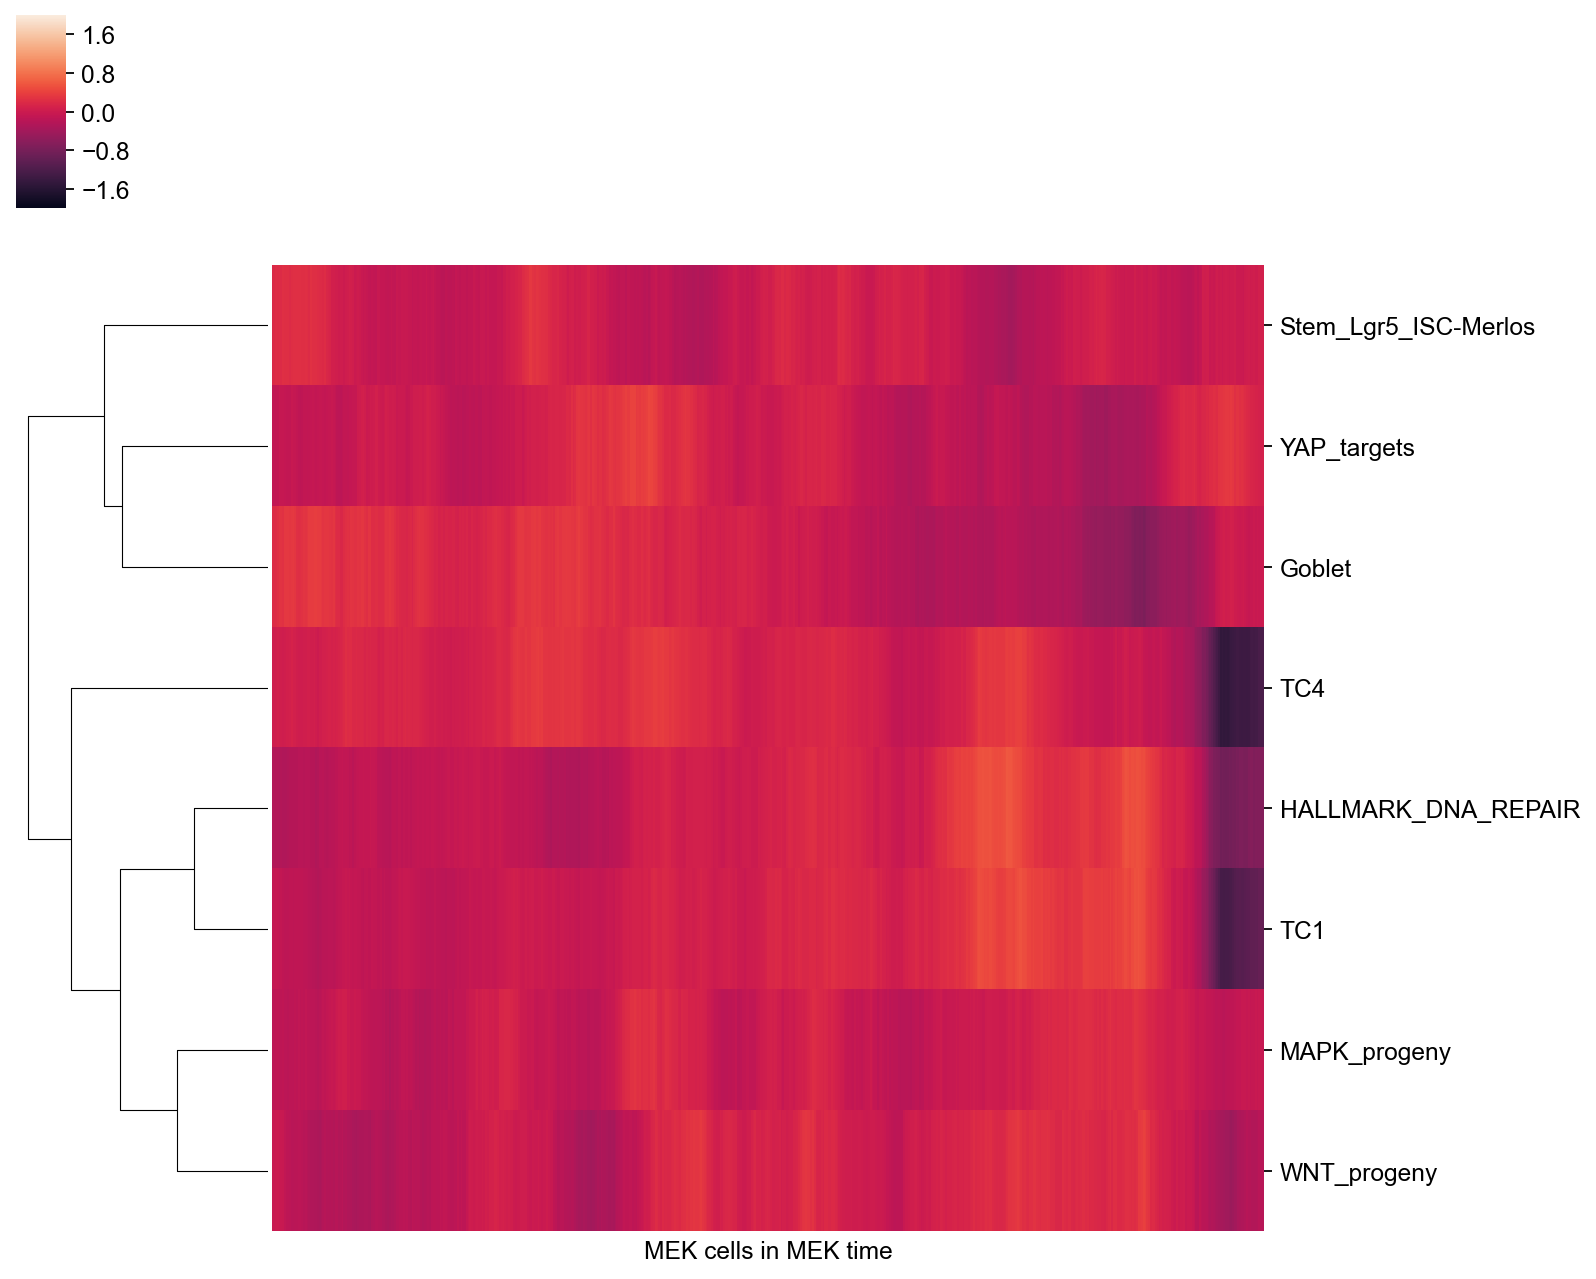

In [39]:
pert2=pert
bdata = adata[adata.obs.perturbation==pert2].copy()
time = dists[adata.obs.perturbation==pert2]
obs_names = np.array(color)
Y=bdata.obs[obs_names].iloc[np.argsort(time)]

#Y/=np.max(np.abs(Y), axis=0)
Y=zscore(Y)
df = pd.DataFrame(Y, columns=obs_names)

if True:
    n_convolve=50
    weights = np.ones(n_convolve) / n_convolve
    for obs in obs_names:
        try:
            df[obs] = np.convolve(df[obs].values, weights, mode="same")
        except:
            pass  # e.g. all-zero counts or nans cannot be convolved

from seaborn import clustermap
cm = clustermap(df.T, row_cluster=True, col_cluster=False, vmin=-2, vmax=2)#, **kwargs
cm.ax_heatmap.set_xlabel(pert2+' cells in '+pert+ ' time');
cm.ax_heatmap.set_xticks([]);

# Panel D
DMSO time for all models

# Dynamic latent time

In [5]:
# load preformated and filtered data (not normalized and logscaled)
donor = donors[0]
adata=sc.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed.h5')
#adata = adata[~np.isin(adata.obs.perturbation, ['DMSO', 'BRAF'])].copy()

In [43]:
scv.tl.recover_dynamics(adata)

recovering dynamics
... 4%WARNING: AL121772.1 not recoverable due to insufficient samples.
... 8%WARNING: APOA2 not recoverable due to insufficient samples.
... 15%WARNING: CATIP not recoverable due to insufficient samples.
... 29%WARNING: skipping bimodality check for DRAXIN
... 71%WARNING: RASGRP3 not recoverable due to insufficient samples.
    finished (0:04:51)


In [45]:
bdata = adata.copy()

In [46]:
adata.uns['recover_dynamics']

{'fit_connected_states': True,
 'fit_basal_transcription': None,
 'use_raw': False}

In [98]:
# save dynamics
var = ['fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling']
layers= ['fit_t', 'fit_tau', 'fit_tau_']
ls ={}
from scipy.sparse import csr_matrix
for l in layers:
    lm = adata.layers[l]
    lm[pd.isna(lm)]=0  # make sparse
    ls[l] = csr_matrix(lm)
bdata=sc.AnnData(obs=adata.obs[[]], var=adata.var[var], layers=ls)
bdata.uns['recover_dynamics']={'fit_connected_states': True, 'fit_basal_transcription': None, 'use_raw': False}
bdata.write(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed_joint_dynamics.h5')

In [8]:
# recall dynamics
var = ['fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling']
layers= ['fit_t', 'fit_tau', 'fit_tau_']
adata=sc.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed.h5')
bdata = scv.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed_joint_dynamics.h5')
for l in layers:
    adata.layers[l] = bdata.layers[l]
for v in var:
    adata.var[v] = bdata.var[v]
adata.uns['recover_dynamics']=bdata.uns['recover_dynamics']

In [9]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities



KeyboardInterrupt



In [ ]:
scv.pl.velocity_embedding_stream(adata, color='perturbation')

In [91]:
bdata.layers['fit_t'][pd.isna(bdata.layers['fit_t'])]=0
from scipy.sparse import csr_matrix
csr_matrix(bdata.layers['fit_t'])

<1509x31915 sparse matrix of type '<class 'numpy.float64'>'
	with 1324196 stored elements in Compressed Sparse Row format>